In [ ]:
# This file aggregates to player level shots attributes and conducts clustering.

# Player-level aggregation

In [1]:
## input: all games
## output: player id, season id, columns with clustering

In [2]:
import pandas as pd, numpy as np
import os
import timeit
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import collections

# Load the data and select the fields needed for this

In [3]:
## reading raw files
# data_root = r"Full Datasets - Opta\MLS"
# full_data = []
# for filename in os.listdir(data_root): 
#     MLS_Part = pd.read_csv(data_root + r'\\' + filename)
#     MLS_Part['season'] = filename.split()[1]
#     full_data.append(MLS_Part)

In [4]:
## already combined, same as the output of above one
fields = ['player_position', 'season', 'competition_id', 'game_id', 'team_id', 'player_id', 'event_type',
         'close_high','close_left', 'close_left_and_high','close_right','close_right_and_high',
         'left', 'high_left', 'high', 'high_right', 'right']
full_data = pd.read_csv('MLS.csv', usecols = fields, encoding='latin-1')

In [5]:
full_data.shape

(3806045, 17)

In [6]:
full_data.head(10)

competition_id         season  game_id     event_type  team_id  player_id  \
0              98  2012-2013.csv   481609          Start     1897        NaN   
1              98  2012-2013.csv   481609          Start     1230        NaN   
2              98  2012-2013.csv   481609           Pass     1897    41469.0   
3              98  2012-2013.csv   481609           Pass     1897    95272.0   
4              98  2012-2013.csv   481609           Pass     1897    48630.0   
5              98  2012-2013.csv   481609           Pass     1897    41653.0   
6              98  2012-2013.csv   481609         Aerial     1230    60218.0   
7              98  2012-2013.csv   481609         Aerial     1897    41469.0   
8              98  2012-2013.csv   481609      Clearance     1230    60218.0   
9              98  2012-2013.csv   481609  Ball recovery     1230     1818.0   

   left  high  right  high_left  high_right  close_left  close_right  \
0   NaN   NaN    NaN        NaN         NaN         NaN          NaN   
1   NaN   NaN    NaN        NaN         NaN         NaN          NaN   
2   NaN   NaN    NaN        NaN         NaN         NaN          NaN   
3   NaN   NaN    NaN        NaN         NaN         NaN          NaN   
4   NaN   NaN    NaN        NaN         NaN         NaN          NaN   
5   NaN   NaN    NaN        NaN         NaN         NaN          NaN   
6   NaN   NaN    NaN        NaN         NaN         NaN          NaN   
7   NaN   NaN    NaN        NaN         NaN         NaN          NaN   
8   NaN   NaN    NaN        NaN         NaN         NaN          NaN   
9   NaN   NaN    NaN        NaN         NaN         NaN          NaN   

   close_high  close_left_and_high  close_right_and_high player_position  
0         NaN                  NaN                   NaN             NaN  
1         NaN                  NaN                   NaN             NaN  
2         NaN                  NaN                   NaN             NaN  
3         NaN                  NaN                   NaN             NaN  
4         NaN                  NaN                   NaN             NaN  
5         NaN                  NaN                   NaN             NaN  
6         NaN                  NaN                   NaN             NaN  
7         NaN                  NaN                   NaN             NaN  
8         NaN                  NaN                   NaN             NaN  
9         NaN                  NaN                   NaN             NaN

# first create positions

In [7]:
shot_players = full_data.loc[full_data['player_position'].isin(['Forward', 'Midfielder', 'Defender'])][['player_id', 'player_position', 'season']]

In [8]:
shot_players.head(5)

player_id player_position         season
1068    41469.0         Forward  2012-2013.csv
1069    57062.0         Forward  2012-2013.csv
1210    48630.0      Midfielder  2012-2013.csv
1211    20568.0      Midfielder  2012-2013.csv
1255    17479.0      Midfielder  2012-2013.csv

In [9]:
shots_players_new = shot_players.groupby(['player_id', 'player_position', 'season']).size().reset_index(name = 'count')\
                                                      .sort_values(['player_id','count', 'season'], ascending = False)\
                                                      .drop_duplicates(subset = ['player_id'], keep = 'first')

In [10]:
shots_players_new['season'].value_counts()

2017-2018.csv    250
2012-2013.csv    218
2018-2019.csv    189
2016-2017.csv    183
2013-2014.csv    177
2015-2016.csv    157
2014-2015.csv    136
Name: season, dtype: int64

## get the forward, middlefielder, and defenders

In [11]:
shots_players_fw = shots_players_new[shots_players_new['player_position'] == 'Forward']

In [12]:
shots_players_mf = shots_players_new[shots_players_new['player_position'] == 'Midfielder']

In [13]:
shots_players_df = shots_players_new[shots_players_new['player_position'] == 'Defender']

# Then create the shot attributes

## filter event type (Strategy: Goal one category, Post and Save combined to one category, Miss is to one cateogry)

In [14]:
shots_type_list = ['Save', 'Miss', 'Post', 'Goal']

In [15]:
shot = full_data.loc[full_data['event_type'].isin(shots_type_list)]

In [16]:
shot.shape

(59677, 17)

# Now group by game/player level

## create the columns corresponding to four categories

### shot outside frame (shot missed)

In [17]:
shot_missed = shot[shot['event_type'] == 'Miss']

In [18]:
close_misses_cols = ['close_high','close_left', 'close_left_and_high','close_right','close_right_and_high']

In [19]:
far_misses_cols = ['left', 'high_left', 'high', 'high_right', 'right']

In [20]:
shot_missed.head()

competition_id         season  game_id event_type  team_id  player_id  \
161              98  2012-2013.csv   481609       Miss     1230     5075.0   
267              98  2012-2013.csv   481609       Miss     1230     5075.0   
327              98  2012-2013.csv   481609       Miss     1897    41469.0   
353              98  2012-2013.csv   481609       Miss     1230    41568.0   
424              98  2012-2013.csv   481609       Miss     1230    82521.0   

     left  high  right  high_left  high_right  close_left  close_right  \
161   1.0   NaN    NaN        NaN         NaN         NaN          NaN   
267   NaN   NaN    NaN        NaN         NaN         NaN          1.0   
327   NaN   NaN    NaN        1.0         NaN         NaN          NaN   
353   NaN   1.0    NaN        NaN         NaN         NaN          NaN   
424   NaN   NaN    NaN        NaN         NaN         1.0          NaN   

     close_high  close_left_and_high  close_right_and_high player_position  
161         NaN                  NaN                   NaN             NaN  
267         NaN                  NaN                   NaN             NaN  
327         NaN                  NaN                   NaN             NaN  
353         NaN                  NaN                   NaN             NaN  
424         NaN                  NaN                   NaN             NaN

In [21]:
shot_missed['shot_missed_close'] = shot_missed[close_misses_cols].apply(np.sum, axis = 1)

E:\coding\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
shot_missed['shot_missed_far'] = shot_missed[far_misses_cols].apply(np.sum, axis = 1)

E:\coding\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
shot_missed_frame_final = shot_missed.groupby(['competition_id', 'game_id', 'team_id', 'player_id', 'season'])\
           .agg({'shot_missed_close': np.sum,
                 'shot_missed_far': np.sum}).reset_index()

In [24]:
shot_missed_frame_final.shape

(17764, 7)

In [25]:
17764*2

35528

### shot inside frame

In [26]:
inframe_list = ['Save', 'Post', 'Goal']

In [27]:
shot_inside_frame = shot.loc[full_data['event_type'].isin(inframe_list)].groupby(['competition_id', 'game_id', 'team_id', 'player_id', 'event_type', 'season'])\
                                             .size().reset_index(name = 'counts').pivot_table(columns = 'event_type', values = 'counts', index = ['competition_id', 'game_id', 'team_id', 'player_id', 'season'])\
                                             .fillna(0).reset_index()

In [28]:
shot_inside_frame['shot_missed_blocked'] = shot_inside_frame['Post'] + shot_inside_frame['Save']

In [29]:
shot_inside_frame = shot_inside_frame.rename(columns = {'Goal': 'shot_goal'})

In [30]:
shot_inside_frame.head(5)

event_type  competition_id  game_id  team_id  player_id         season  \
0                       98   429860      436    41474.0  2012-2013.csv   
1                       98   429860      436    41627.0  2012-2013.csv   
2                       98   429860      436    60225.0  2012-2013.csv   
3                       98   429860      454    18324.0  2012-2013.csv   
4                       98   429860      454    33808.0  2012-2013.csv   

event_type  shot_goal  Post  Save  shot_missed_blocked  
0                 0.0   0.0   3.0                  3.0  
1                 1.0   0.0   1.0                  1.0  
2                 1.0   0.0   0.0                  0.0  
3                 0.0   0.0   1.0                  1.0  
4                 0.0   0.0   3.0                  3.0

In [31]:
shot_inside_frame.head

<bound method NDFrame.head of event_type  competition_id  game_id  team_id  player_id         season  \
0                       98   429860      436    41474.0  2012-2013.csv   
1                       98   429860      436    41627.0  2012-2013.csv   
2                       98   429860      436    60225.0  2012-2013.csv   
3                       98   429860      454    18324.0  2012-2013.csv   
4                       98   429860      454    33808.0  2012-2013.csv   
5                       98   429860      454    41503.0  2012-2013.csv   
6                       98   429861     1616     7166.0  2012-2013.csv   
7                       98   429861     1616    17762.0  2012-2013.csv   
8                       98   429861     1616    94387.0  2012-2013.csv   
9                       98   429861     1616    95442.0  2012-2013.csv   
10                      98   429861     1708    12891.0  2012-2013.csv   
11                      98   429861     1708    15600.0  2012-2013.csv   
12      

In [32]:
shot_inside_frame_to_join = shot_inside_frame[['competition_id', 'game_id', 'team_id', 'player_id', 'shot_goal', 'shot_missed_blocked', 'season']]

In [33]:
shot_final = shot_missed_frame_final.merge(shot_inside_frame_to_join, how = 'outer').fillna(0)

In [34]:
shot_final.columns

Index(['competition_id', 'game_id', 'team_id', 'player_id', 'season',
       'shot_missed_close', 'shot_missed_far', 'shot_goal',
       'shot_missed_blocked'],
      dtype='object')

In [35]:
shot_final.shape

(33362, 9)

### shot_missed_blocked: either defensor blocking or goalkeeper blocking the shot (within target)

# Now aggregate the data to player level

In [36]:
shot_final_avged = shot_final.drop(['team_id'], axis = 1).groupby(['player_id', 'season']).sum().reset_index()

# Now Modeling

## For forward (treat the same person in different season just as one, directly run clustering)

In [37]:
shot_fwd = shot_final_avged[shot_final_avged['player_id'].isin(shots_players_fw['player_id'])]
shot_nfwd = shot_final_avged[~shot_final_avged['player_id'].isin(shots_players_fw['player_id'])]
# shot_fwd = shot_final_avged[shot_final_avged['player_id'].isin(shots_players_mf['player_id'])]
# shot_fwd = shot_final_avged[shot_final_avged['player_id'].isin(set(list(shots_players_fw['player_id']) + list(shots_players_mf['player_id']) + list(shots_players_df['player_id'])))]

In [38]:
shot_fwd.shape

(676, 8)

In [39]:
shot_nfwd.shape

(2674, 8)

In [40]:
shot_fwd.columns

Index(['player_id', 'season', 'competition_id', 'game_id', 'shot_missed_close',
       'shot_missed_far', 'shot_goal', 'shot_missed_blocked'],
      dtype='object')

## now standardize

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def getSdDF(featureSet):
    originalCols = featureSet.columns
    featureSet = featureSet.drop(['season', 'competition_id', 'game_id', 'player_id'],1)    
    num_cols = featureSet.shape[1]
    scaler = StandardScaler()
    scaler.fit(featureSet)
    featureSet = scaler.transform(featureSet)
    returnDF = pd.DataFrame(featureSet)
    returnDF.columns = originalCols[4:]
    
    return returnDF

In [42]:
sd_fields = getSdDF(shot_fwd)

In [43]:
sd_fields.head()

shot_missed_close  shot_missed_far  shot_goal  shot_missed_blocked
0           1.324464         1.673046   2.030285             0.526432
1           2.165946         2.915728   1.055794             1.971092
2           3.007429         2.363425   1.055794             0.526432
3           1.114093         1.396894   3.394572             1.489539
4           0.482981         1.258819   2.225183             0.526432

# modeling, decide number of clusters

In [44]:
# To capture model objects for each k
GMM_models = []

# Upper bound for range of k to try 
kmax = 10
for k in range(3, kmax):  
    # Create model object
    model = GaussianMixture(n_components=k, covariance_type='full', random_state=1234)
    model.fit(sd_fields)
    GMM_models.append(model)

In [45]:
n_components = range(3, kmax)
plt.plot(n_components, [m.bic(sd_fields) for m in GMM_models], label='BIC')
plt.plot(n_components, [m.aic(sd_fields) for m in GMM_models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

Text(0.5,0,'n_components')

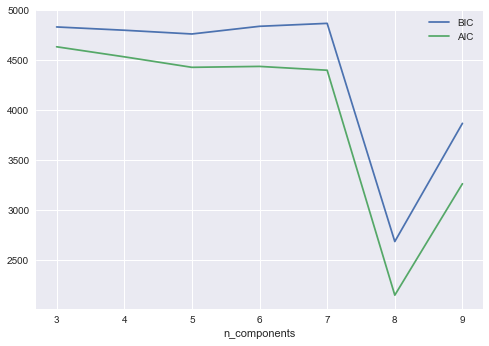

In [46]:
plt.show()

# do 8 clusters

In [47]:
bestGMM = GMM_models[5]
# bestGMM = GMM_models[1]
bestGMM_center = pd.concat([pd.DataFrame(bestGMM.means_),pd.DataFrame(bestGMM.weights_).rename(columns={0:'weight'})],axis=1)

In [48]:
bestGMM_center = bestGMM_center.reset_index().rename(columns={'index':'cluster'})

In [49]:
bestGMM_center

cluster         0         1         2         3    weight
0        0  1.564729  1.571346  1.866365  1.609690  0.024939
1        1 -0.469852 -0.513460 -0.490817 -0.918228  0.225260
2        2  0.959115  0.528174  0.452462  1.108989  0.130338
3        3 -0.798618 -0.886335 -0.893187 -0.633053  0.156160
4        4  0.099751  0.079142  0.040188  0.241725  0.168615
5        5 -0.599782 -0.532411 -0.481935 -0.114668  0.146827
6        6  2.687572  2.820565  2.239906  1.962590  0.034515
7        7  0.397028  1.001517  1.157489  0.258934  0.113346

In [336]:
nameDict = {0:sd_fields.columns[0],1:sd_fields.columns[1],2:sd_fields.columns[2],3:sd_fields.columns[3]}
sns.heatmap(bestGMM_center.set_index('cluster').rename(columns = nameDict),annot=True)

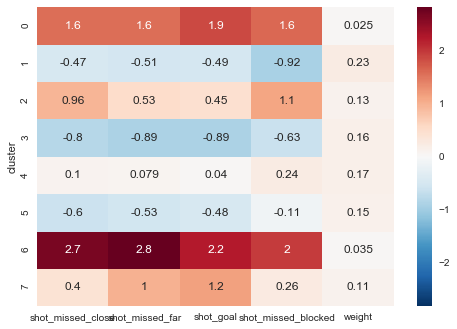

In [337]:
plt.show()

# Now predict

In [53]:
shot_fwd['cluster_shoot_raw'] = bestGMM.predict(sd_fields)

E:\coding\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
shot_fwd.columns

Index(['player_id', 'season', 'competition_id', 'game_id', 'shot_missed_close',
       'shot_missed_far', 'shot_goal', 'shot_missed_blocked',
       'cluster_shoot_raw'],
      dtype='object')

#### combine the clusters

In [55]:
shot_fwd['cluster_shoot'] = np.where(((shot_fwd['cluster_shoot_raw'] == 1) | (shot_fwd['cluster_shoot_raw'] == 4)), 
                                                 1, np.where((shot_fwd['cluster_shoot_raw'] == 3) | (shot_fwd['cluster_shoot_raw'] == 5), 3, 
                                                             np.where(shot_fwd['cluster_shoot_raw'] == 6, 4,
                                                                     np.where(shot_fwd['cluster_shoot_raw'] == 7, 5, shot_fwd['cluster_shoot_raw']))))

E:\coding\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [56]:
shot_fwd['cluster_shoot'].value_counts()

1    254
3    227
2     82
5     75
4     22
0     16
Name: cluster_shoot, dtype: int64

In [57]:
shot_nfwd['cluster_shoot'] = 6; # define as cluster 6, as non-forward are not modeled.

E:\coding\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
# cluster 0: efficient star-shooters, 
# cluster 1: average attackers, 
# cluster 2: inefficient shooters, 
# cluster 3: non-shooters, 
# cluster 4: superstar shooters (not necessarily efficient), 
# cluster 5: effieicient shooters,
# cluster 6: other ppl (non-attackers)

In [59]:
all_shots_final = pd.concat([shot_fwd, shot_nfwd], ignore_index=True)
all_shots_out = all_shots_final[['player_id', 'season', 'cluster_shoot']]

In [60]:
all_shots_out.shape

(3350, 3)

## recalculate the center

In [62]:
sd_fields['player_id'] = shot_fwd['player_id']
sd_fields['season'] = shot_fwd['season']

In [73]:
center_df_cal = shot_fwd[['player_id', 'season', 'cluster_shoot']]

In [74]:
joined = center_df_cal.merge(sd_fields, on = ['season', 'player_id'], how = 'left')

In [75]:
new_GMM_center = joined.groupby(['cluster_shoot']).mean().drop('player_id', 1).reset_index()

In [79]:
nameDict = {0:sd_fields.columns[0],1:sd_fields.columns[1],2:sd_fields.columns[2],3:sd_fields.columns[3]}
sns.heatmap(new_GMM_center.set_index('cluster_shoot').rename(columns = nameDict),annot=True,cmap="YlGnBu")

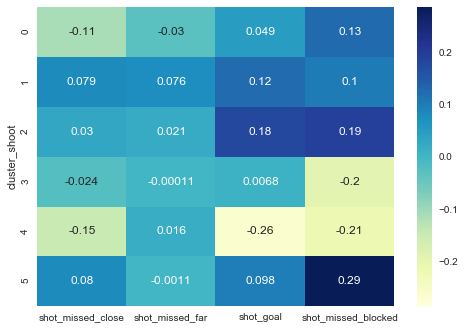

In [80]:
plt.show()

In [ ]:
# coming up with the names (renamed for final product)
# cluster 0: inefficient shooters, 
# cluster 1: efficient shooters, 
# cluster 2: prolific shooters, 
# cluster 3: average, 
# cluster 4: non-shooters, 
# cluster 5: super ineffieicient shooters,

In [81]:
new_GMM_center.to_csv('new_GMM_center.csv', index = False)

In [358]:
all_shots_out.to_csv('shoot_result.csv', index = False)